In [27]:
import torch
import os
from PIL import Image 
import numpy as np


class AddDataset:
    def __init__(self, root_dir, transform):
        root_dir = 'I:\GIT\Hair Diseases'
        assert os.path.exists(root_dir), 'Data does not exist'
        self.transform = transform
        data_files = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)]
        data_label = 0
        self.data_all = {}
        self.data_all['label'] = []
        self.data_all['file_name'] = []
        for file in data_files:    
            data_samples = os.listdir(file)
            for data in data_samples:
                data_file_name = os.path.join(file, data)
                self.data_all['label'].append(data_label)
                self.data_all['file_name'].append(data_file_name)
            data_label += 1 

    def __len__(self):
        return len(self.data_all['label'])

    def __getitem__(self, index):
        # print(self.data[index])
        assert index < len(self.data_all['file_name']), 'Index out of range'
        image = Image.open(self.data_all['file_name'][index])
        #newsize = (256,256)
        #image = image.resize(newsize)
        image = np.array(image)
        label = np.array(self.data_all['label'][index])

        if self.transform:
            image = torch.from_numpy(image)
            label = torch.from_numpy(label)

        data_point = {'label': label, 'image': image}
        return data_point    

In [28]:
import torch
import random
import torch.utils.data as data
from torch.utils.data import DataLoader

root_dir = 'I:\GIT\Hair Diseases\train'
dataset = AddDataset(root_dir, transform=True)

#train_size = int(0.8*len(dataset))
train_size = int(len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = data.random_split(dataset,[train_size, val_size])

batch_size = 8
dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [29]:
!pip install matplotlib

tensor(0, dtype=torch.int32)
torch.Size([472, 720, 3])


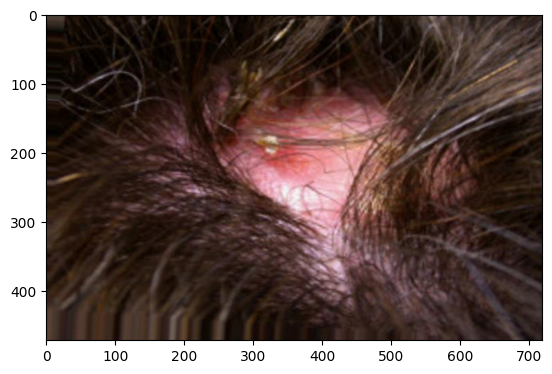

In [40]:
import matplotlib.pyplot as plt
test = dataset[50]
test_image = test['image']
plt.imshow(test_image)

print(test['label'])
print(test_image.shape)

In [41]:
# ngpu = 0
import torch.nn as nn

class MyNetwork(nn.Module):
    def __init__(self, ngpu):
        super(MyNetwork, self).__init__()
        self.ngpu = ngpu
        self.main = nn. Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3), stride = (1,1), padding='valid', bias = True, padding_mode='zeros'),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride = (1,1), padding='valid', bias = True, padding_mode='zeros'),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride = (1,1), padding='valid', bias = True, padding_mode='zeros'),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(115200, 512, bias=True),
            nn.ReLU(True),
            nn.Linear(512, 5, bias=True),
            nn.Softmax(dim=1)

        )
    def forward(self, input):
        return self.main(input)

In [43]:
!pip install torchsummary


In [50]:
from torchsummary import summary


ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


net = MyNetwork(ngpu =1).to(device)


# net.share_memory()


#summary(net, [3,512,512])
#summary(net, [(3,512,512)])
summary(net, input_size=[(3, 256, 256)])



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 254, 254]             224
              ReLU-2          [-1, 8, 254, 254]               0
         MaxPool2d-3          [-1, 8, 127, 127]               0
            Conv2d-4         [-1, 16, 125, 125]           1,168
              ReLU-5         [-1, 16, 125, 125]               0
         MaxPool2d-6           [-1, 16, 62, 62]               0
            Conv2d-7           [-1, 32, 60, 60]           4,640
              ReLU-8           [-1, 32, 60, 60]               0
           Flatten-9               [-1, 115200]               0
           Linear-10                  [-1, 512]      58,982,912
             ReLU-11                  [-1, 512]               0
           Linear-12                    [-1, 5]           2,565
          Softmax-13                    [-1, 5]               0
Total params: 58,991,509
Trainable para

In [51]:
SGD_optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


loss_func = nn.CrossEntropyLoss()



num_epochs = 10

In [53]:
import torch.nn.functional as F
import torchvision.transforms as transforms

for epoch in range(num_epochs):
    # train_accuracy = 0
    for i, data in enumerate(dataloader_train,0):

        SGD_optimizer.zero_grad()

        input = data['image'].to(device)
        
        label = data['label'].to(device)

        label_train = label.to(torch.int64)
        label_encoded = F.one_hot(label_train,5).squeeze(1)


        out = net(input)

        # print(out.shape)
        loss = loss_func(out, label_encoded)
        loss.backward()
        SGD_optimizer.step()

        print(loss)

        #import torchvision.transforms as transforms

# Convert input tensor to PIL image
input_image = transforms.ToPILImage()(input)

# Convert PIL image back to tensor with 3 channels
input_tensor = transforms.ToTensor()(input_image)


RuntimeError: Given groups=1, weight of size [8, 3, 3, 3], expected input[8, 472, 720, 3] to have 3 channels, but got 472 channels instead